In [63]:
import pandas as pd

In [146]:
pd.set_option('display.max_colwidth', None)

intents_corpus = pd.read_csv("./travel_corpus.csv")
intents_corpus.sample(10)

,response,text,label
131,[''],Give me the price for a flight ticket from Hanover to Basel,SearchFlight
125,[''],Can I info for one-way trip from Dublin to Porto?,SearchFlight
164,[''],Find me roundtrip price between Toronto and Hong Kong between Jan 14 and Feb 28,SearchFlight
203,[''],Available hotels in Venice?,SearchHotel
31,"['Hello, how can I help you?', 'Good to see you again', 'Hi there, how can I help?']",Hey man,greeting
152,[''],Roundtrip flight between San Jose and New York City leaving on Feb 2 and returning on Feb 5?,SearchFlight
127,[''],"From Madrid to Vienna, one-way flight",SearchFlight
24,"['Hello, how can I help you?', 'Good to see you again', 'Hi there, how can I help?']",yo,greeting
93,"['I can provide you with flights and hotel information', 'I can help you look up information on flight and or hotels prices based on the date and location you provide to me']","Help me, what can you do?",options
128,[''],Find me the price for one way trip from Hanover to Basel,SearchFlight


In [147]:
intents_corpus[['response', 'text', 'label']][:10]

,response,text,label
0,"['Hello, how can I help you?', 'Good to see you again', 'Hi there, how can I help?']",Hi there,greeting
1,"['Hello, how can I help you?', 'Good to see you again', 'Hi there, how can I help?']",hi there,greeting
2,"['Hello, how can I help you?', 'Good to see you again', 'Hi there, how can I help?']",Hello?,greeting
3,"['Hello, how can I help you?', 'Good to see you again', 'Hi there, how can I help?']",hi can you help me?,greeting
4,"['Hello, how can I help you?', 'Good to see you again', 'Hi there, how can I help?']",hey again,greeting
5,"['Hello, how can I help you?', 'Good to see you again', 'Hi there, how can I help?']",hey man,greeting
6,"['Hello, how can I help you?', 'Good to see you again', 'Hi there, how can I help?']",hey there,greeting
7,"['Hello, how can I help you?', 'Good to see you again', 'Hi there, how can I help?']",hello? anyone?,greeting
8,"['Hello, how can I help you?', 'Good to see you again', 'Hi there, how can I help?']",hi again,greeting
9,"['Hello, how can I help you?', 'Good to see you again', 'Hi there, how can I help?']",hello,greeting


In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer().fit(intents_corpus.text)
train_corpus = vectorizer.transform(intents_corpus.text)
train_corpus.shape

(227, 263)

In [149]:
from sklearn.metrics.pairwise import cosine_similarity

def get_most_similar_sentence(cue, vectorizer,  train_corpus, top_n=3):
    # compute similarity to all sentences in the training corpus
    similarities = cosine_similarity(vectorizer.transform([cue]), train_corpus).flatten()
    # get indexes of top 3 closest sentences
    related_docs_indices = similarities.argsort()[:-top_n:-1]

    most_relevant_idx = related_docs_indices[0]
    # return triples of (similarity score, sentence, label)
    return (most_relevant_idx, similarities[most_relevant_idx], intents_corpus['text'].values[most_relevant_idx])

In [150]:
get_most_similar_sentence('I want to fly from New York to Otava', vectorizer, train_corpus)

(157,
 0.3966436388187975,
 'I have to fly from Osaka to Toronto, leaving on Dec 1')

In [151]:
(idx, similarity, text) = get_most_similar_sentence('I want to fly from New York to Otava', vectorizer, train_corpus)
label = intents_corpus['label'].values[idx]
print(label)

SearchFlight


In [152]:
def predict(message):
    (idx, similarity, text) = get_most_similar_sentence(message, vectorizer, train_corpus)
    label = intents_corpus['label'].values[idx]
    return similarity, text, label

# Tests 

In [153]:
similarity, text_from_corpus,predicted_label = predict("I want to fly from New York to Ottawa")
print("Most similar text from the corpus: ", text_from_corpus)
print("Similarity: ", similarity)
print("Predicted label: ", predicted_label)

Most similar text from the corpus:  Want to know price of round trip from Ottawa to Calgary
Similarity:  0.43413600322889323
Predicted label:  SearchFlight


In [154]:
similarity, text_from_corpus,predicted_label = predict("Can you find me a flight ticket from New York to Ottawa on Feb 14?")
print("Most similar text from the corpus: ", text_from_corpus)
print("Similarity: ", similarity)
print("Predicted label: ", predicted_label)

Most similar text from the corpus:  Flight from San Jose to New York City leaving on Feb 2 and returning on Feb 5?
Similarity:  0.4799200011300324
Predicted label:  SearchFlight


In [155]:
similarity, text_from_corpus,predicted_label = predict("What hotels are available in New York?")
print("Most similar text from the corpus: ", text_from_corpus)
print("Similarity: ", similarity)
print("Predicted label: ", predicted_label)

Most similar text from the corpus:  What hotels are available in San Francisco?
Similarity:  0.5525458590931
Predicted label:  SearchHotel


In [156]:
similarity, text_from_corpus,predicted_label = predict("Can you find a flight from San Francisco to Los Angeles on 2 March?")
print("Most similar text from the corpus: ", text_from_corpus)
print("Similarity: ", similarity)
print("Predicted label: ", predicted_label)

Most similar text from the corpus:  hotels in Los Angeles
Similarity:  0.4831144325911081
Predicted label:  SearchHotel


# With Lemmatizer and stop words

In [157]:
import nltk
import string # to process standard python strings
from nltk.stem import WordNetLemmatizer

# Preprocessing
lemmer = WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmer.lemmatize(token) for token in tokens]
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [159]:

vectorizer2 = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english').fit(intents_corpus.text)
train_corpus2 = vectorizer2.transform(intents_corpus.text)
train_corpus2.shape

def predict2(message):
    (idx, similarity, text) = get_most_similar_sentence(message, vectorizer2, train_corpus2)
    label = intents_corpus['label'].values[idx]
    return similarity, text, label

In [160]:
similarity, text_from_corpus,predicted_label = predict("I want to fly from New York to Otava")
print("Most similar text from the corpus: ", text_from_corpus)
print("Similarity: ", similarity)
print("Predicted label: ", predicted_label)

Most similar text from the corpus:  I have to fly from Osaka to Toronto, leaving on Dec 1
Similarity:  0.3966436388187975
Predicted label:  SearchFlight


In [161]:
similarity, text_from_corpus,predicted_label = predict("What hotels are available in New York?")
print("Most similar text from the corpus: ", text_from_corpus)
print("Similarity: ", similarity)
print("Predicted label: ", predicted_label)

Most similar text from the corpus:  What hotels are available in San Francisco?
Similarity:  0.5525458590931
Predicted label:  SearchHotel


In [162]:
similarity, text_from_corpus, predicted_label = predict("Could you reffer to me some good hotels in Amsterdam?")
print("Most similar text from the corpus: ", text_from_corpus)
print("Similarity: ", similarity)
print("Predicted label: ", predicted_label)

Most similar text from the corpus:  I will be in Amsterdam for a couple of days, could you please reffer some hotels?
Similarity:  0.6004224875900397
Predicted label:  SearchHotel


In [163]:
similarity, text_from_corpus, predicted_label = predict("Awesome, thank you very much, bot!")
print("Most similar text from the corpus: ", text_from_corpus)
print("Similarity: ", similarity)
print("Predicted label: ", predicted_label)

Most similar text from the corpus:  thank you very much!
Similarity:  0.7555952121152602
Predicted label:  thanks


In [164]:
similarity, text_from_corpus, predicted_label = predict("What are the best hotels in Amsterdam?")
print("Most similar text from the corpus: ", text_from_corpus)
print("Similarity: ", similarity)
print("Predicted label: ", predicted_label)

Most similar text from the corpus:  you are the best, thanks
Similarity:  0.5491357757903066
Predicted label:  thanks


The last test shows us that the prediction depends mainly on the available sentences in the corpus, which in some cases leads to unexpected results.
That's why the NLP processing is crucial for getting better and more reliable answers.

# Evaluation with confusion matrix

In [165]:
# Train/test split
travel_intents = intents_corpus[['text', 'label']]
travel_train_df = travel_intents.sample(frac=0.8, random_state=42)
test_df = travel_intents.drop(travel_train_df.index)
test_df['label'].value_counts()


SearchHotel     14
SearchFlight    13
goodbye          6
greeting         4
thanks           4
options          4
Name: label, dtype: int64

In [167]:
evaluation_vectorizer = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english').fit(travel_train_df.text)
evaluation_train_corpus = evaluation_vectorizer.transform(travel_train_df.text)

def evaluation_predict(message):
    (idx, similarity, text) = get_most_similar_sentence(message, evaluation_vectorizer, evaluation_train_corpus)
    label = travel_train_df['label'].values[idx]
    return label

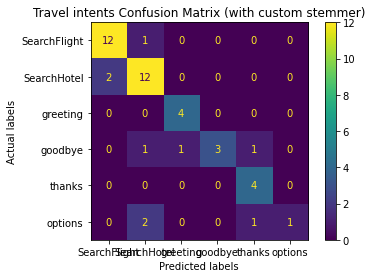

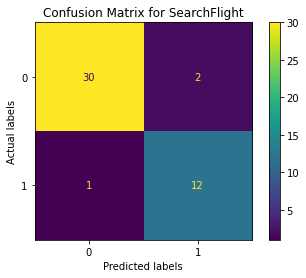

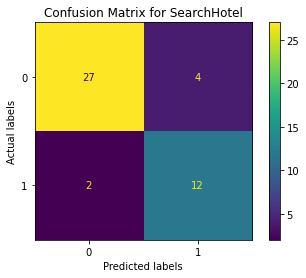

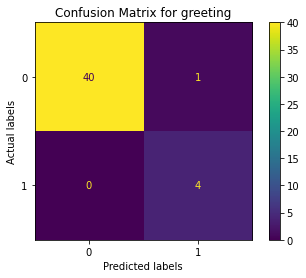

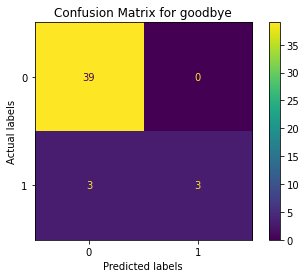

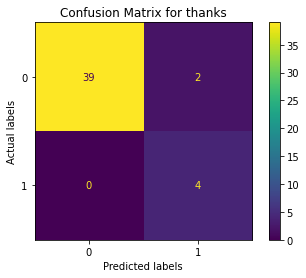

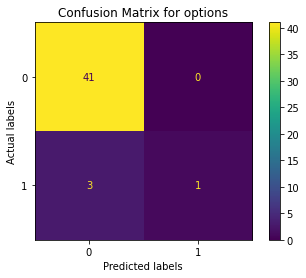

In [173]:
# !pip3 install matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix,ConfusionMatrixDisplay

expected_labels = []
predicted_labels = []

for index, row in test_df.iterrows():
    expected_labels.append(row['label'])
    pred_label = evaluation_predict(row['text'])
    predicted_labels.append(pred_label)

unique_labels = ['SearchFlight','SearchHotel','greeting','goodbye','thanks','options']
conf_matrix = confusion_matrix(expected_labels, predicted_labels, labels=unique_labels)
cmd_obj = ConfusionMatrixDisplay(conf_matrix, display_labels=unique_labels)
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Travel intents Confusion Matrix (with custom stemmer)', 
                xlabel='Predicted labels', 
                ylabel='Actual labels')
plt.show()

# Calculate confusion matrix for each label
conf_matrix_for_each = multilabel_confusion_matrix(expected_labels, predicted_labels, labels=unique_labels)
i=0
for m in conf_matrix_for_each:
    cmd_obj = ConfusionMatrixDisplay(m)
    cmd_obj.plot()
    cmd_obj.ax_.set(
                title='Confusion Matrix for ' + unique_labels[i], 
                xlabel='Predicted labels', 
                ylabel='Actual labels')
    plt.show()
    i+=1


# Evaluate the algorithm without using custom lemmatizer and stop words

In [171]:
evaluation_vectorizer_without_stemming = TfidfVectorizer().fit(travel_train_df.text)
evaluation_train_corpus_without_stemming = evaluation_vectorizer_without_stemming.transform(travel_train_df.text)

def evaluation_predict_without_stemming(message):
    (idx, similarity, text) = get_most_similar_sentence(message, evaluation_vectorizer_without_stemming, evaluation_train_corpus_without_stemming)
    label = travel_train_df['label'].values[idx]
    return label

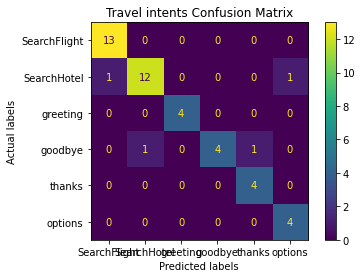

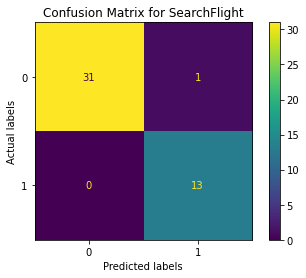

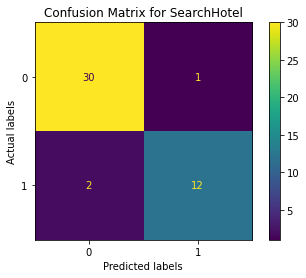

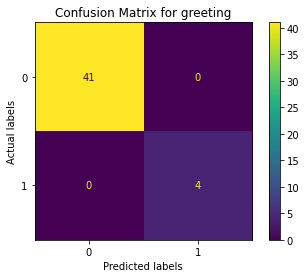

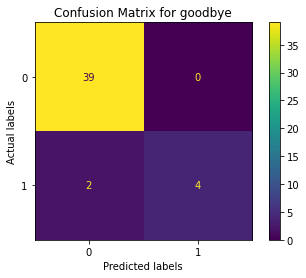

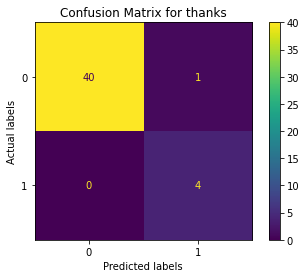

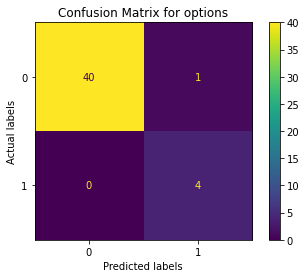

In [172]:
expected_labels = []
predicted_labels = []

for index, row in test_df.iterrows():
    expected_labels.append(row['label'])
    pred_label = evaluation_predict_without_stemming(row['text'])
    predicted_labels.append(pred_label)

unique_labels = ['SearchFlight','SearchHotel','greeting','goodbye','thanks','options']
conf_matrix = confusion_matrix(expected_labels, predicted_labels, labels=unique_labels)
cmd_obj = ConfusionMatrixDisplay(conf_matrix, display_labels=unique_labels)
cmd_obj.plot()
cmd_obj.ax_.set(
                title='Travel intents Confusion Matrix', 
                xlabel='Predicted labels', 
                ylabel='Actual labels')
plt.show()

# Calculate confusion matrix for each label
conf_matrix_for_each = multilabel_confusion_matrix(expected_labels, predicted_labels, labels=unique_labels)
i=0
for m in conf_matrix_for_each:
    cmd_obj = ConfusionMatrixDisplay(m)
    cmd_obj.plot()
    cmd_obj.ax_.set(
                title='Confusion Matrix for ' + unique_labels[i], 
                xlabel='Predicted labels', 
                ylabel='Actual labels')
    plt.show()
    i+=1